In [3]:
import random
import sqlite3

def generate_and_save_mTSP_instances_to_db(nr_instances, nr_cities, nr_salesmen = 1, coord_range=(0, 100), db_file="mTSP_instances.sqlite3"):

    # Connect to the database
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Create the tables
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS instances (
            instance_id INTEGER PRIMARY KEY,
            nr_cities INTEGER,
            nr_salesmen INTEGER
        )
    """)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS cities (
            city_id INTEGER,
            instance_id INTEGER,
            x INTEGER,
            y INTEGER,
            PRIMARY KEY (city_id, instance_id),
            FOREIGN KEY (instance_id) REFERENCES instances(instance_id)
        )
    """)

    # Find next instance_id
    cursor.execute("SELECT MAX(instance_id) FROM instances")
    result = cursor.fetchone()
    next_instance_id = result[0] + 1 if result[0] is not None else 1

    # Create and save instances
    for instance_id in range(next_instance_id, next_instance_id + nr_instances):

        # instace
        cursor.execute("INSERT INTO instances (instance_id, nr_cities, nr_salesmen) VALUES (?, ?, ?)",
                       (instance_id, nr_cities, nr_salesmen))

        # cities
        for city_id in range(nr_cities + 1):
            x = random.randint(coord_range[0], coord_range[1])
            y = random.randint(coord_range[0], coord_range[1])
            cursor.execute("INSERT INTO cities (city_id, instance_id, x, y) VALUES (?, ?, ?, ?)",
                           (city_id, instance_id, x, y))

    conn.commit()
    conn.close()

    print(f"{nr_instances} mTSP instances were created and added to {db_file}.")


generate_and_save_mTSP_instances_to_db(nr_instances=10, nr_cities=5, nr_salesmen=3, coord_range=(0, 100), db_file="train_mTSP.sqlite3")

10 mTSP instances were created and added to train_mTSP.sqlite3.


In [9]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def solve_tsp_with_or_tools(distance_matrix, nr_salesmen):
    # Create the routing manager and model
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), nr_salesmen, 0)
    routing = pywrapcp.RoutingModel(manager)

    # Define cost of each arc
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Solve the problem
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC) 
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)  
    search_parameters.time_limit.seconds = 30 

    solution = routing.SolveWithParameters(search_parameters)

    # Extract the solution
    if solution:
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        return route, solution.ObjectiveValue()
    else:
        return None, None
 
def set_optimal_cost_of_instances(db_file="mTSP.sqlite3"):

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Add the optimal cost column to the instances table
    cursor.execute("PRAGMA table_info(instances)")
    columns = [column[1] for column in cursor.fetchall()]
    if "optimal_cost" not in columns:
        cursor.execute("ALTER TABLE instances ADD COLUMN optimal_cost REAL")

    # Fetch all instances
    cursor.execute("SELECT instance_id, nr_salesmen FROM instances WHERE optimal_cost IS NULL")
    instances = cursor.fetchall()

    for (instance_id, nr_salesmen) in instances:
    
        cursor.execute("SELECT x, y FROM cities WHERE instance_id = ?", (instance_id,))
        cities = cursor.fetchall()

        # Create distance matrix
        distance_matrix = [[
            ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5 for x2, y2 in cities
        ] for x1, y1 in cities]

        # Solve with ortools algorithm
        _, optimal_cost = solve_tsp_with_or_tools(distance_matrix, nr_salesmen)

        cursor.execute(
            "UPDATE instances SET optimal_cost = ? WHERE instance_id = ?",
            (optimal_cost, instance_id)
        )

    conn.commit()
    conn.close()

    print("Evaluation completed. Optimal costs saved to the database.")

set_optimal_cost_of_instances(db_file="train_mTSP.sqlite3")

Evaluation completed. Optimal costs saved to the database.


In [7]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def solve_tsp_with_or_tools_fast(distance_matrix, nr_salesmen):
    # Create the routing manager and model
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), nr_salesmen, 0)
    routing = pywrapcp.RoutingModel(manager)

    # Define cost of each arc
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Solve the problem
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    # Extract the solution
    if solution:
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        return route, solution.ObjectiveValue()
    else:
        return None, None
 
def set_fast_optimal_cost_of_instances(db_file="mTSP.sqlite3"):

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Add the optimal cost column to the instances table
    cursor.execute("PRAGMA table_info(instances)")
    columns = [column[1] for column in cursor.fetchall()]
    if "optimal_cost_fast" not in columns:
        cursor.execute("ALTER TABLE instances ADD COLUMN optimal_cost_fast REAL")

    # Fetch all instances
    cursor.execute("SELECT instance_id, nr_salesmen FROM instances")
    instances = cursor.fetchall()

    for (instance_id, nr_salesmen) in instances:
    
        cursor.execute("SELECT x, y FROM cities WHERE instance_id = ?", (instance_id,))
        cities = cursor.fetchall()

        # Create distance matrix
        distance_matrix = [[
            ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5 for x2, y2 in cities
        ] for x1, y1 in cities]

        # Solve with ortools algorithm
        _, optimal_cost_fast = solve_tsp_with_or_tools_fast(distance_matrix, nr_salesmen)

        cursor.execute(
            "UPDATE instances SET optimal_cost_fast = ? WHERE instance_id = ?",
            (optimal_cost_fast, instance_id)
        )

    conn.commit()
    conn.close()

    print("Evaluation completed. Fast optimal costs saved to the database.")

set_fast_optimal_cost_of_instances(db_file="train_mTSP.sqlite3")

Evaluation completed. Fast optimal costs saved to the database.


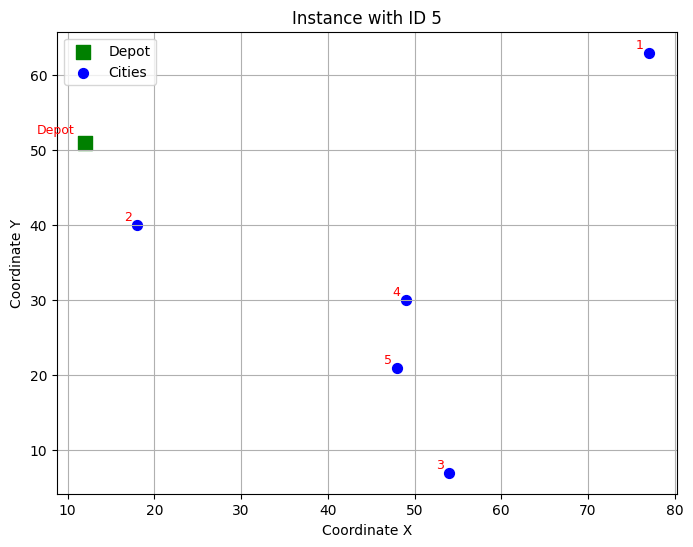

In [11]:
import sqlite3
import matplotlib.pyplot as plt

def plot_mTSP_instance(instance_id, db_file="mTSP_instances.sqlite3"):

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Verify if instance exists
    cursor.execute("SELECT * FROM instances WHERE instance_id = ?", (instance_id,))
    instance = cursor.fetchone()
    if instance is None:
        print(f"The instance with the ID {instance_id} does not exist.")
        conn.close()
        return

    # Get city coordinates
    cursor.execute("SELECT city_id, x, y FROM cities WHERE instance_id = ?", (instance_id,))
    cities = cursor.fetchall()

    if not cities:
        print(f"The instance with the ID {instance_id} does not have cities.")
        conn.close()
        return

    conn.close()

    # Plot the cities
    plt.figure(figsize=(8, 6))
    for city_id, x, y in cities:
        if city_id == 0: 
            plt.scatter(x, y, c='green', marker='s', label='Depot', s=100)  
            plt.text(x - 1.2, y + 1.2, 'Depot', fontsize=9, ha='right', color='red')
        else:
            plt.scatter(x, y, c='blue', label='Cities' if city_id == 1 else "", s=50)  
            plt.text(x - 0.6, y + 0.6, str(city_id), fontsize=9, ha='right', color='red')


    plt.title(f"Instance with ID {instance_id}")
    plt.xlabel("Coordinate X")
    plt.ylabel("Coordinate Y")
    plt.grid(True)
    plt.legend()
    plt.show()

# 
plot_mTSP_instance(instance_id=5, db_file="train_mTSP.sqlite3")